# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ML_lib
import importlib
import os

# for debug purposes, reload the module to reflect recent changes
importlib.reload(ML_lib)

<module 'ML_lib' from 'c:\\Users\\maxim\\Godot Games\\Snake\\python-test-folder\\ML_lib.py'>

# Loading CSV data

In [2]:

def load_and_preprocess_data(data_path):
    # iterate over all the csv files in the data_path, remove the header and combine them into one np.array
    data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    data_list = []

    print(f"Found {len(data_files)} csv files in {data_path}")

    for file in data_files:
        file_path = os.path.join(data_path, file)
        try:
            data = np.loadtxt(file_path, delimiter=',', skiprows=1)
            if data.size > 0:
                # Ensure 2D array even if single line
                if len(data.shape) == 1:
                    data = data.reshape(1, -1)
                data_list.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_list:
        print("No data loaded.")
        return None, None

    combined_data = np.concatenate(data_list, axis=0)
    print(f"Original combined shape: {combined_data.shape}")

    # Filter rows where score (col 1) resets to 0 in the next row, but is not 0 itself
    # Logic: (current_score != 0) AND (next_score == 0) -> Remove current
    
    to_remove = np.zeros(len(combined_data), dtype=bool)
    
    # Check condition for all rows except the last one
    # Column 1 is the score column
    to_remove[:-1] = (combined_data[:-1, 1] != 0) & (combined_data[1:, 1] == 0)
    
    num_removed = np.sum(to_remove)
    print(f"Removing {num_removed} rows where score resets to 0.")
    
    combined_data_filtered = combined_data[~to_remove]
    
    # Remove the first column (index 0) gameOver not relevant
    combined_data_final = combined_data_filtered[:, 1:]
    
    print(f"Shape after filtering rows and removing first column: {combined_data_final.shape}")

    # use the last 4 row as the prediction and the rest as the features
    X = combined_data_final[:, :-4]
    Y = combined_data_final[:, -4:]

    print(f"Final X shape: {X.shape}")
    print(f"Final Y shape: {Y.shape}")
    
    # print the size of X in MB
    print("Size of X: ", X.nbytes / 1e6, "MB")
    
    return X, Y

In [3]:
X, Y = load_and_preprocess_data("../Data/")

Found 2 csv files in ../Data/
Original combined shape: (7322, 525)
Removing 20 rows where score resets to 0.
Shape after filtering rows and removing first column: (7302, 524)
Final X shape: (7302, 520)
Final Y shape: (7302, 4)
Size of X:  30.37632 MB


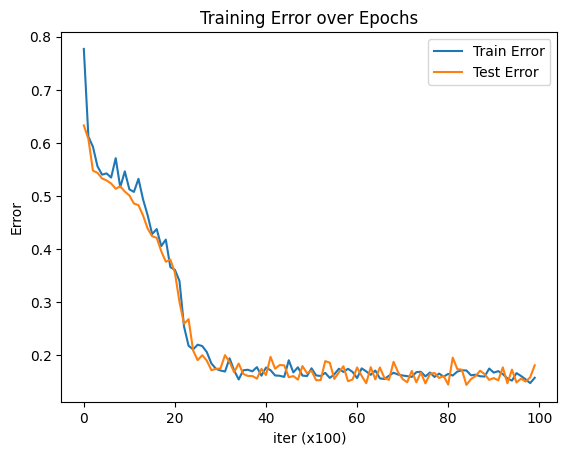

In [4]:
mlp = ML_lib.MLP([520, 256, 128, 64, 32, 4], True)

num_iter = 10_000
error_list_size = 100

train_err, test_err = mlp.train(X.T, Y.T, num_iter = num_iter, lr=0.01, 
                            train_proportion=0.9, error_list_size=error_list_size)

plt.plot(train_err, label="Train Error")
plt.plot(test_err, label="Test Error")
plt.xlabel(f"iter (x{num_iter//error_list_size})")
plt.ylabel("Error")
plt.title("Training Error over Epochs")
plt.legend()
plt.show()

In [5]:
mlp.save("..\\Models\\7302X_520+256+128+64+32+4_10kiter_0.01lr_0.9train.bin")

In [6]:
# Predict 10 random samples from X and print them and the corresponding Y
for _ in range(10):
    idx = np.random.randint(0, X.shape[0])
    x_sample = X[idx, :].reshape(-1, 1)
    y_true = Y[idx, :].reshape(-1, 1)
    y_pred = mlp.predict(x_sample)
    print(f"Sample {idx}:")
    print(f"  True Output: {y_true.ravel()}")
    print(f"  Predicted Output: {y_pred.ravel()}")

Sample 5940:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.48506514 0.5163039  0.12133752 0.10837792]
Sample 4993:
  True Output: [1. 0. 0. 0.]
  Predicted Output: [ 0.6330994   0.47997622 -0.02894787  0.06484058]
Sample 6144:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [ 0.65406957  0.48822269 -0.01346013  0.02940186]
Sample 6301:
  True Output: [1. 0. 0. 0.]
  Predicted Output: [0.49393408 0.47370913 0.00254548 0.22397411]
Sample 1473:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.47865571 0.49496135 0.23426301 0.07118941]
Sample 2510:
  True Output: [1. 0. 0. 0.]
  Predicted Output: [0.45426461 0.46433782 0.23892678 0.10600271]
Sample 4369:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.47631957 0.49856502 0.24874801 0.07158855]
Sample 1901:
  True Output: [0. 0. 1. 0.]
  Predicted Output: [0.49266139 0.49067916 0.10303983 0.133194  ]
Sample 2113:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [ 0.50283184  0.5729971  -0.15175304  0.20884588]
Sample 4585:
  T

In [7]:
loaded_mlp = ML_lib.MLP.load("..\\Models\\7302X_520+256+128+64+32+4_10kiter_0.01lr_0.9train.bin")
loaded_mlp_predict = loaded_mlp.predict(x_sample)
print(f"Loaded MLP Predicted Output: {loaded_mlp_predict.shape}")

Loaded MLP Predicted Output: (4,)
